<a href="https://colab.research.google.com/github/SergeiVKalinin/pyro/blob/master/ss_reg_VAE_ferroic_v1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/ziatdinovmax/pyroved@ss_reg_vae --upgrade
!pip install git+https://github.com/pycroscopy/atomai --upgrade

  Cloning https://github.com/ziatdinovmax/pyroved (to revision ss_reg_vae) to /tmp/pip-req-build-m5xiwe8h
  Running command git clone -q https://github.com/ziatdinovmax/pyroved /tmp/pip-req-build-m5xiwe8h
  Running command git checkout -b ss_reg_vae --track origin/ss_reg_vae
  Switched to a new branch 'ss_reg_vae'
  Branch 'ss_reg_vae' set up to track remote branch 'ss_reg_vae' from 'origin'.
     |████████████████████████████████| 634kB 14.9MB/s 
  Created wheel for pyroved: filename=pyroved-0.2.1-cp37-none-any.whl size=46280 sha256=1919399929543eb71beab78dec472ddec841b0c97f8c3bf7c887ef3deca42b2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldcu914g/wheels/02/51/15/66f71b72e2fed28dde8d2625f4d0e461c95c276ac330361bf1
Successfully built pyroved
  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-iowbmyxm
  Running command git clone -q https://github.com/pycroscopy/atomai /tmp/pip-req-build-iowbmyxm
     |████████████████████████████████| 194kB 14.0MB/s 
     |██████

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
import torch
import atomai as aoi
import pyroved as pv

Load data:

In [ ]:
dataset_all = aoi.utils.datasets.stem_smbfo(download=True)
dataset_all.keys()

If you use this dataset in your work, please consider citing it using the following DOI: https://doi.org/10.13139/ORNLNCCS/1773704.


100% (2230521337 of 2230521337) |########| Elapsed Time: 0:00:20 Time:  0:00:20


dict_keys(['Sm_0_0', 'Sm_0_1', 'Sm_0_2', 'Sm_10_0', 'Sm_10_1', 'Sm_13_0', 'Sm_13_1', 'Sm_20_0', 'Sm_20_1', 'Sm_7_0', 'Sm_7_1', 'Sm_7_2', 'Sm_7_3', 'Sm_7_4'])

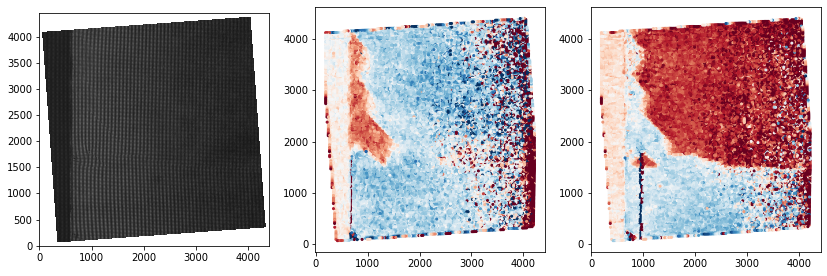

In [ ]:
dataset = dataset_all["Sm_0_1"]

main_img = dataset["main_image"]
Pxy = dataset["Pxy"]
xy_com = dataset["xy_COM"]
xy_atms = dataset['xy_atms']

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4.5))
ax1.imshow(main_img, cmap="gray", origin="lower")
ax2.scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax3.scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 1], cmap='RdBu', vmin=-4, vmax=4)
plt.show()

Extract image patches:

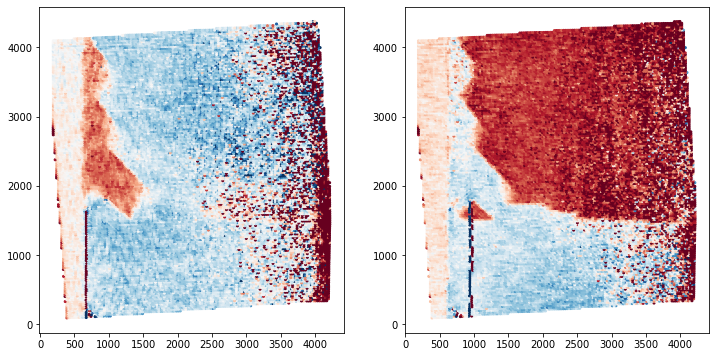

In [ ]:
window_size = 42

imgstack, xy_stack, _ = aoi.utils.extract_subimages(
    main_img[None, ..., None], xy_atms, window_size, coord_class=0)
imgstack = imgstack[..., 0]

tree = cKDTree(xy_com)
d, idx = tree.query(xy_stack, distance_upper_bound=14)
idx = idx[d!=np.inf]
xy_stack = xy_com[idx]
Pxy_stack = Pxy[idx]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=Pxy_stack[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax2.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=Pxy_stack[:, 1], cmap='RdBu', vmin=-4, vmax=4)

The ss-reg-VAE consists of a standard encoder-decoder block and an MLP regressor. The latter will learn to predict polarization on the entire dataset from a small number of image patches for which a polarization is known.

First, let's see how well this approach works for one of the polarization components (i.e. single-output regressor):

In [ ]:
X = imgstack
X = (X - X.min()) / X.ptp()

n, d1, d2 = X.shape
X = X.reshape(n, d1 * d2)

y = Pxy_stack[:, 0:1]

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

Define labeled and unlabeled parts of the data:

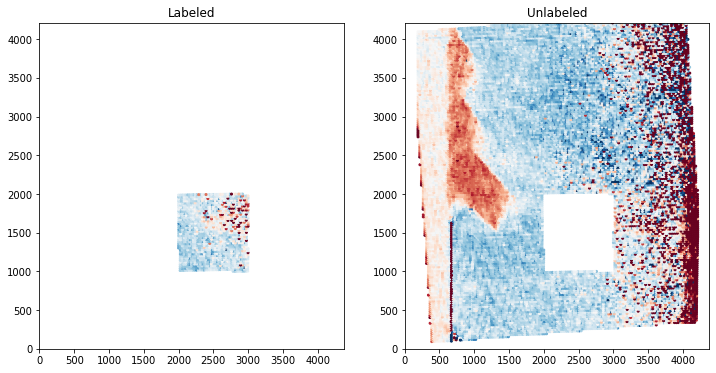

In [ ]:
bool1 = np.logical_and(xy_stack[:, 0] > 1000, xy_stack[:, 0] < 2000)
bool2 = np.logical_and(xy_stack[:, 1] > 2000, xy_stack[:, 1] < 3000)
bool12 = bool1*bool2
X_u, X_l = X[~bool12], X[bool12]
y_u, y_l = y[~bool12], y[bool12]
xy_u, xy_l = xy_stack[~bool12], xy_stack[bool12]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
xlim, ylim = (0, xy_stack[:, 0].max()), (0, xy_stack[:, 1].max())
ax1.scatter(xy_l[:, 1], xy_l[:, 0], s=4, c=y_l[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax2.scatter(xy_u[:, 1], xy_u[:, 0], s=4, c=y_u[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax1.set_title("Labeled")
ax2.set_title("Unlabeled")
for _ax in fig.axes:
    _ax.set_xlim(*xlim)
    _ax.set_ylim(*ylim)

Initialize the dataloaders:

(note that because we actually know polarization values for the unlabeled part, we are going to use this information to evaluate/validate our model at each step)

In [ ]:
loader_unsup, loader_sup, loader_val = pv.utils.init_ssvae_dataloaders(X_u, (X_l, y_l), (X_u, y_u))

Define a model:

In [ ]:
latent_dim = 2 # we are using only one latent variable

data_dim = imgstack.shape[1:]
model = pv.models.ss_reg_iVAE(data_dim, latent_dim, reg_dim=1)  

Train a model:

In [ ]:
trainer = pv.trainers.auxSVItrainer(model, task="regression", lr=1e-4)

for i in range(32):
    trainer.step(loader_unsup, loader_sup, loader_val, aux_loss_multiplier=200)
    trainer.print_statistics()
    if i > 20:  # optional
        trainer.save_running_weights("encoder_y")
trainer.average_weights("encoder_y")

Epoch: 1 Training loss: 936.9191, Test MSE: 722.2944
Epoch: 2 Training loss: 850.1690, Test MSE: 567.0837
Epoch: 3 Training loss: 840.8815, Test MSE: 471.6593
Epoch: 4 Training loss: 832.5978, Test MSE: 457.3444
Epoch: 5 Training loss: 825.9176, Test MSE: 407.9638
Epoch: 6 Training loss: 823.0510, Test MSE: 359.5996
Epoch: 7 Training loss: 822.1840, Test MSE: 368.4708
Epoch: 8 Training loss: 821.7583, Test MSE: 314.5217
Epoch: 9 Training loss: 821.6842, Test MSE: 353.8459
Epoch: 10 Training loss: 821.4692, Test MSE: 298.3746
Epoch: 11 Training loss: 821.2197, Test MSE: 316.8827
Epoch: 12 Training loss: 821.0785, Test MSE: 274.3196
Epoch: 13 Training loss: 821.1809, Test MSE: 277.1629
Epoch: 14 Training loss: 821.0139, Test MSE: 293.8747
Epoch: 15 Training loss: 820.8203, Test MSE: 480.9755
Epoch: 16 Training loss: 820.8378, Test MSE: 265.2868
Epoch: 17 Training loss: 820.9122, Test MSE: 319.4600
Epoch: 18 Training loss: 820.7535, Test MSE: 264.5450
Epoch: 19 Training loss: 820.6550, Te

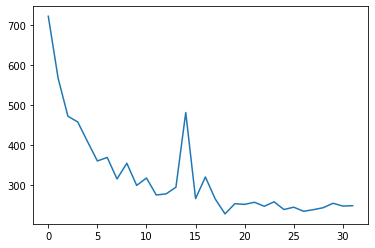

In [ ]:
plt.plot(trainer.history["test"])

Make a prediction on the entire data and plot results:

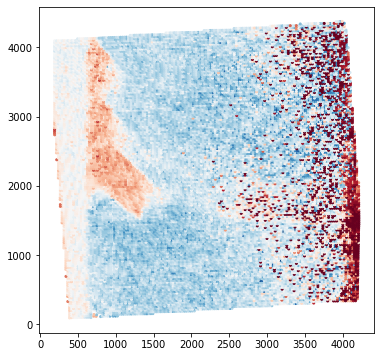

In [ ]:
y_pred = model.regressor(X)

plt.figure(figsize=(6, 6))
plt.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=y_pred[:, 0], cmap='RdBu', vmin=-4, vmax=4)

Now let's train our model to predict a different polarization component:

In [ ]:
X = imgstack
X = (X - X.min()) / X.ptp()

n, d1, d2 = X.shape
X = X.reshape(n, d1 * d2)

y = Pxy_stack[:, 1:2]

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

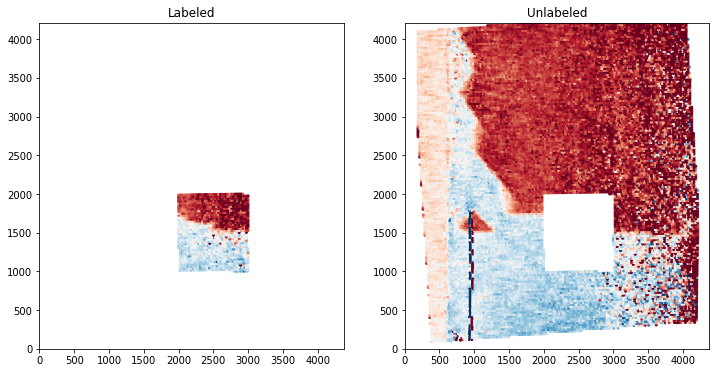

In [ ]:
bool1 = np.logical_and(xy_stack[:, 0] > 1000, xy_stack[:, 0] < 2000)
bool2 = np.logical_and(xy_stack[:, 1] > 2000, xy_stack[:, 1] < 3000)
bool12 = bool1*bool2
X_u, X_l = X[~bool12], X[bool12]
y_u, y_l = y[~bool12], y[bool12]
xy_u, xy_l = xy_stack[~bool12], xy_stack[bool12]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
xlim, ylim = (0, xy_stack[:, 0].max()), (0, xy_stack[:, 1].max())
ax1.scatter(xy_l[:, 1], xy_l[:, 0], s=4, c=y_l[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax2.scatter(xy_u[:, 1], xy_u[:, 0], s=4, c=y_u[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax1.set_title("Labeled")
ax2.set_title("Unlabeled")
for _ax in fig.axes:
    _ax.set_xlim(*xlim)
    _ax.set_ylim(*ylim)

In [ ]:
loader_unsup, loader_sup, loader_val = pv.utils.init_ssvae_dataloaders(X_u, (X_l, y_l), (X_u, y_u))

Define a model:

In [ ]:
latent_dim = 2 # we are using only one latent variable

data_dim = imgstack.shape[1:]
model = pv.models.ss_reg_iVAE(data_dim, latent_dim, reg_dim=1)  

Train a model:

In [ ]:
trainer = pv.trainers.auxSVItrainer(model, task="regression", lr=1e-4)

for i in range(32):
    trainer.step(loader_unsup, loader_sup, loader_val, aux_loss_multiplier=200)
    trainer.print_statistics()
    if i > 20: # optional
        trainer.save_running_weights("encoder_y")
trainer.average_weights("encoder_y")

Epoch: 1 Training loss: 939.5516, Test MSE: 335.1729
Epoch: 2 Training loss: 855.6702, Test MSE: 291.6970
Epoch: 3 Training loss: 846.4321, Test MSE: 269.5554
Epoch: 4 Training loss: 838.3501, Test MSE: 252.6977
Epoch: 5 Training loss: 835.4564, Test MSE: 229.7233
Epoch: 6 Training loss: 833.9531, Test MSE: 232.8988
Epoch: 7 Training loss: 832.3419, Test MSE: 209.5150
Epoch: 8 Training loss: 828.7486, Test MSE: 196.8522
Epoch: 9 Training loss: 828.1373, Test MSE: 201.5828
Epoch: 10 Training loss: 827.4976, Test MSE: 217.0052
Epoch: 11 Training loss: 827.0266, Test MSE: 203.4454
Epoch: 12 Training loss: 827.0635, Test MSE: 186.0396
Epoch: 13 Training loss: 826.4435, Test MSE: 186.4063
Epoch: 14 Training loss: 826.4440, Test MSE: 217.2266
Epoch: 15 Training loss: 826.3283, Test MSE: 178.8257
Epoch: 16 Training loss: 825.9920, Test MSE: 180.4302
Epoch: 17 Training loss: 826.1774, Test MSE: 174.6411
Epoch: 18 Training loss: 825.7583, Test MSE: 176.7306
Epoch: 19 Training loss: 825.6546, Te

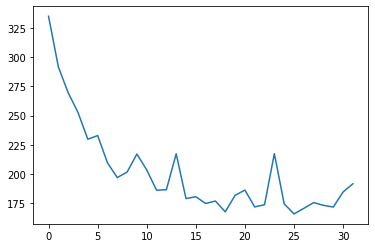

In [ ]:
plt.plot(trainer.history["test"])

Make a prediction on the entire data and plot results:

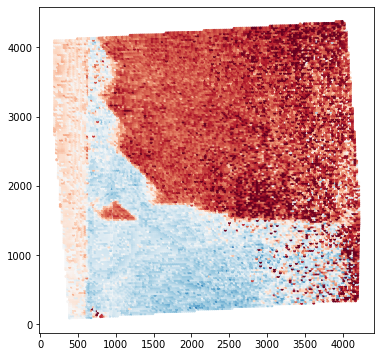

In [ ]:
y_pred = model.regressor(X)

plt.figure(figsize=(6, 6))
plt.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=y_pred[:, 0], cmap='RdBu', vmin=-4, vmax=4)

Now let's do a multi-output regression, i.e. we will be predicting both polarization components at the same time

In [ ]:
X = imgstack
X = (X - X.min()) / X.ptp()

n, d1, d2 = X.shape
X = X.reshape(n, d1 * d2)

y = Pxy_stack[:, 0:2]

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

In [ ]:
bool1 = np.logical_and(xy_stack[:, 0] > 1000, xy_stack[:, 0] < 2000)
bool2 = np.logical_and(xy_stack[:, 1] > 2000, xy_stack[:, 1] < 3000)
bool12 = bool1*bool2
X_u, X_l = X[~bool12], X[bool12]
y_u, y_l = y[~bool12], y[bool12]
xy_u, xy_l = xy_stack[~bool12], xy_stack[bool12]

In [ ]:
loader_unsup, loader_sup, loader_val = pv.utils.init_ssvae_dataloaders(X_u, (X_l, y_l), (X_u, y_u))

Define a model:

In [ ]:
latent_dim = 2 # we are using only one latent variable

data_dim = imgstack.shape[1:]
model = pv.models.ss_reg_iVAE(data_dim, latent_dim, reg_dim=2)  

Train a model:

In [ ]:
trainer = pv.trainers.auxSVItrainer(model, task="regression", lr=1e-4)

for i in range(32):
    trainer.step(loader_unsup, loader_sup, loader_val, aux_loss_multiplier=200)
    trainer.print_statistics()
    if i > 20:  # optional
        trainer.save_running_weights("encoder_y")
trainer.average_weights("encoder_y")

Epoch: 1 Training loss: 938.1655, Test MSE: 626.3695
Epoch: 2 Training loss: 857.2069, Test MSE: 489.6050
Epoch: 3 Training loss: 843.7463, Test MSE: 389.9666
Epoch: 4 Training loss: 835.6978, Test MSE: 360.8447
Epoch: 5 Training loss: 832.2231, Test MSE: 310.0255
Epoch: 6 Training loss: 832.2474, Test MSE: 313.0301
Epoch: 7 Training loss: 830.7587, Test MSE: 275.2303
Epoch: 8 Training loss: 831.0170, Test MSE: 266.1905
Epoch: 9 Training loss: 830.6442, Test MSE: 276.3266
Epoch: 10 Training loss: 830.3794, Test MSE: 262.4908
Epoch: 11 Training loss: 830.1189, Test MSE: 256.1208
Epoch: 12 Training loss: 829.9828, Test MSE: 245.6006
Epoch: 13 Training loss: 829.6839, Test MSE: 253.6916
Epoch: 14 Training loss: 829.2745, Test MSE: 236.2948
Epoch: 15 Training loss: 829.5157, Test MSE: 345.6741
Epoch: 16 Training loss: 829.0259, Test MSE: 243.2497
Epoch: 17 Training loss: 829.1544, Test MSE: 229.9170
Epoch: 18 Training loss: 828.9170, Test MSE: 227.9283
Epoch: 19 Training loss: 828.7213, Te

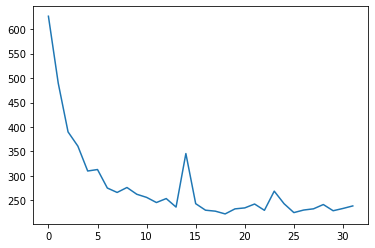

In [ ]:
plt.plot(trainer.history["test"])

Make a prediction on the entire data and plot results:

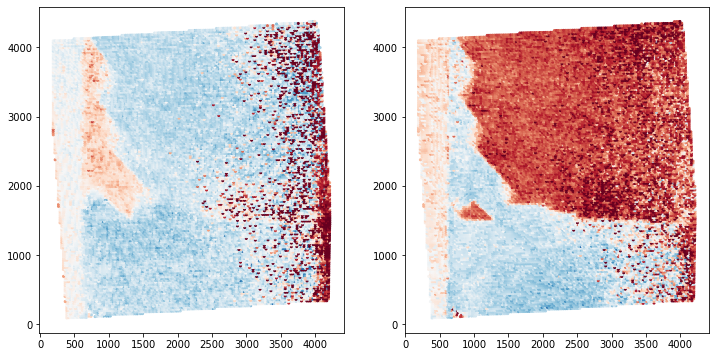

In [ ]:
y_pred = model.regressor(X)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=y_pred[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax2.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=y_pred[:, 1], cmap='RdBu', vmin=-4, vmax=4)

Compare the distribution of predicted polarization...

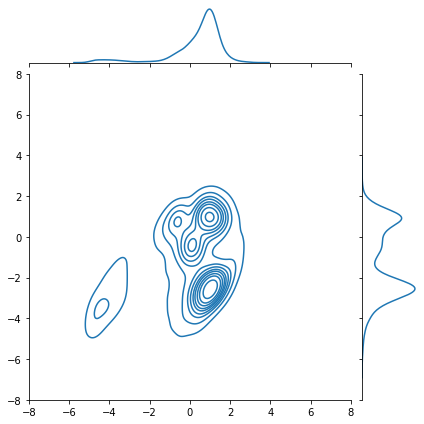

In [ ]:
import seaborn as sns

sns.jointplot(x=y_pred[:,0].numpy(), y=y_pred[:,1].numpy(), kind="kde", xlim=(-8, 8), ylim=(-8, 8));

... with the distribution of "ground truth" polarization

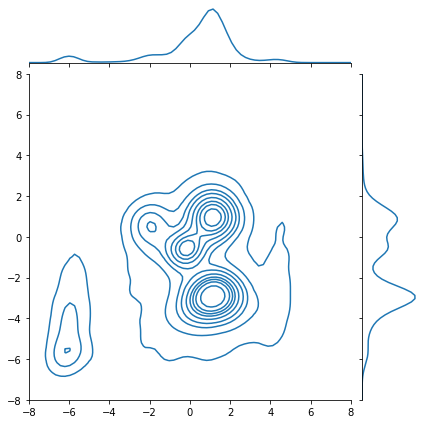

In [ ]:
sns.jointplot(x=y[:, 0], y=y[:, 1], kind="kde", xlim=(-8, 8), ylim=(-8, 8));

Plot the learned latent manifold for a specfic value of of "polarization":

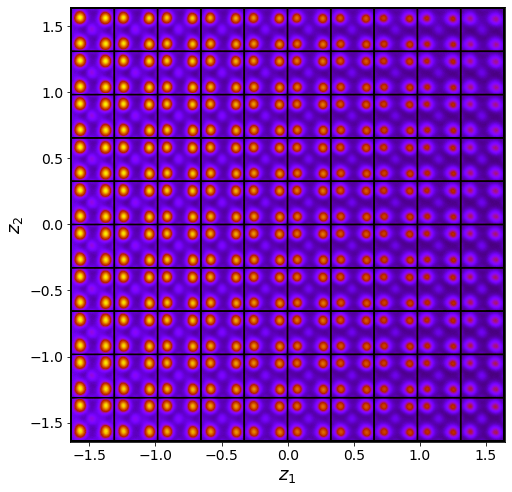

In [ ]:
model.manifold2d(d=10, y=torch.tensor([1., 1.]).unsqueeze(0));